In [14]:
import requests
import time
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
import csv
from typing import List, Dict, Any, Optional, Callable
from dataclasses import dataclass
from enum import Enum
from typing import Tuple
from collections import defaultdict

In [8]:
class ResultStatus(Enum):
    PASSED = "PASSED"
    FAILED = "FAILED"
    ERROR = "ERROR"


@dataclass
class TestCaseResult:
    status: ResultStatus
    response_time_ms: Optional[float]
    http_status_code: Optional[int]
    data: Optional[Dict[str, Any]]
    error_message: Optional[str]
    timestamp: float

    def __post_init__(self):
        if self.timestamp is None:
            self.timestamp = time.time()

    @property
    def is_successful(self) -> bool:
        return self.status == ResultStatus.PASSED

    @property
    def is_error(self) -> bool:
        return self.status == ResultStatus.ERROR

    def to_dict(self) -> Dict[str, Any]:
        return {
            "time": self.response_time_ms,
            "result": self.status.value,
            "http_status": self.http_status_code,
            "error_message": self.error_message,
            "timestamp": self.timestamp
        }


class Test:
    def __init__(self,
                 name: str,
                 endpoint: str,
                 request_payload: str,
                 validator: Callable[[Dict[str, Any]], bool],
                 num_requests: int = 20,
                 num_warmup_requests: int = 1,
                 request_timeout: int = 30):
        self.name = name
        self.endpoint = endpoint
        self.request_payload = request_payload
        self.validator = validator
        self.results: List[TestCaseResult] = []

        # Request configuration
        self.num_requests = num_requests
        self.num_warmup_requests = num_warmup_requests
        self.request_timeout = request_timeout
        self.headers = {
            "Content-Type": "application/json",
            "Accept": "application/json"
        }

        # Retry configuration
        self.initial_delay = 20
        self.max_delay = 100
        self.step_delay = 1

    def _send_request(self, payload: Dict[str, Any]) -> TestCaseResult:
        start_time = time.perf_counter()

        try:
            response = requests.post(
                self.endpoint,
                json=payload,
                headers=self.headers,
                timeout=self.request_timeout
            )
            end_time = time.perf_counter()
            response_time_ms = (end_time - start_time) * 1000

            response.raise_for_status()
            data = response.json() if response.content else None

            # Check if data is empty
            # (e.g., rate limiter error)
            if not data:
                return TestCaseResult(
                    status=ResultStatus.ERROR,
                    response_time_ms=response_time_ms,
                    http_status_code=response.status_code,
                    data=None,
                    error_message="Empty data returned",
                    timestamp=time.time()
                )

            return TestCaseResult(
                status=ResultStatus.PASSED,
                response_time_ms=response_time_ms,
                http_status_code=response.status_code,
                data=data,
                error_message=None,
                timestamp=time.time()
            )

        except requests.exceptions.Timeout:
            end_time = time.perf_counter()
            response_time_ms = (end_time - start_time) * 1000
            return TestCaseResult(
                status=ResultStatus.ERROR,
                response_time_ms=response_time_ms,
                http_status_code=None,
                data=None,
                error_message="Request timed out",
                timestamp=time.time()
            )

        except requests.exceptions.ConnectionError as e:
            return TestCaseResult(
                status=ResultStatus.ERROR,
                response_time_ms=None,
                http_status_code=None,
                data=None,
                error_message=f"Connection error: {e}",
                timestamp=time.time()
            )

        except requests.exceptions.RequestException as e:
            end_time = time.perf_counter()
            response_time_ms = (end_time - start_time) * 1000
            return TestCaseResult(
                status=ResultStatus.ERROR,
                response_time_ms=response_time_ms,
                http_status_code=getattr(e.response, 'status_code', None) if hasattr(e, 'response') else None,
                data=None,
                error_message=f"Request failed: {e}",
                timestamp=time.time()
            )

        except Exception as e:
            return TestCaseResult(
                status=ResultStatus.ERROR,
                response_time_ms=None,
                http_status_code=None,
                data=None,
                error_message=f"Unexpected error: {e}",
                timestamp=time.time()
            )

    def _execute_test_case(self) -> TestCaseResult:
        payload = {"request": self.request_payload}
        result = self._send_request(payload)

        if result.status == ResultStatus.PASSED:
            # Validate the response
            if self.validator(result.data):
                print(f"✓ Valid response [{result.data}]")
                return result
            else:
                print(f"✗ Invalid response [{result.data}]")
                return TestCaseResult(
                    status=ResultStatus.FAILED,
                    response_time_ms=result.response_time_ms,
                    http_status_code=result.http_status_code,
                    data=result.data,
                    error_message="Response validation failed",
                    timestamp=result.timestamp
                )
        else:
            print(f"✗ Request failed: {result.error_message}")
            return result

    def _run_warmup(self):
        print(f"Starting warmup phase ({self.num_warmup_requests} requests)...")
        for i in range(self.num_warmup_requests):
            print(f"Warmup {i+1}/{self.num_warmup_requests}")
            self._execute_test_case()
        print("✓ Warmup phase complete.\n")

    def run(self) -> List[TestCaseResult]:
        """Execute the complete test suite."""
        print(f"- Starting test: {self.name}")
        print(f"- Endpoint: {self.endpoint}")
        print(f"- Request: {self.request_payload}")
        print("=" * 80)

        self.results.clear()

        # Run warmup
        self._run_warmup()

        # Run actual tests
        print(f"Starting test phase ({self.num_requests} successful requests targeted)...")

        requests_made = 0
        current_delay = self.initial_delay

        while requests_made < self.num_requests:
            print(f"Request {requests_made + 1}/{self.num_requests}")

            try:
                result = self._execute_test_case()

                if result.status in [ResultStatus.PASSED, ResultStatus.FAILED]:
                    self.results.append(result)
                    requests_made += 1
                    current_delay = self.initial_delay
                    time.sleep(self.step_delay)
                else:
                    print(f"⚠ Error encountered. Retrying after {current_delay:.2f} seconds...")
                    time.sleep(current_delay)
                    current_delay = min(current_delay * 2, self.max_delay)

            except Exception as e:
                print(f"⚠ Unexpected error: {e}. Retrying after {current_delay:.2f} seconds...")
                time.sleep(current_delay)
                current_delay = min(current_delay * 2, self.max_delay)

        self._print_summary()
        return self.results

    def _print_summary(self):
        """Print test execution summary."""
        passed_count = sum(1 for r in self.results if r.status == ResultStatus.PASSED)
        failed_count = sum(1 for r in self.results if r.status == ResultStatus.FAILED)

        execution_times = [r.response_time_ms for r in self.results if r.response_time_ms is not None]
        avg_time = sum(execution_times) / len(execution_times) if execution_times else 0

        print("\n" + "="*80)
        print(f"Test Summary for: {self.name}")
        print(f"- PASSED: {passed_count}")
        print(f"- FAILED: {failed_count}")
        print(f"- Total: {len(self.results)}")
        print(f"- Average Response Time: {avg_time:.2f} ms")
        print(f"- Success Rate: {(passed_count/len(self.results)*100):.1f}%" if self.results else "N/A")
        print("="*80)

    def save_results(self, filename: str):
        if not self.results:
            print("No results to save.")
            return

        try:
            with open(filename, 'w', newline='') as csvfile:
                writer = csv.DictWriter(csvfile, fieldnames=['time', 'result', 'http_status', 'error_message', 'timestamp'])
                writer.writeheader()
                writer.writerows([result.to_dict() for result in self.results])
            print(f"Results saved to {filename}")
        except IOError as e:
            print(f"Error saving results: {e}")

    def get_metrics(self) -> Dict[str, Any]:
        if not self.results:
            return {}

        times = [r.response_time_ms for r in self.results if r.response_time_ms is not None]
        passed_count = sum(1 for r in self.results if r.status == ResultStatus.PASSED)

        return {
            'name': self.name,
            'total_requests': len(self.results),
            'passed_requests': passed_count,
            'failed_requests': len(self.results) - passed_count,
            'success_rate': passed_count / len(self.results) if self.results else 0,
            'avg_response_time': sum(times) / len(times) if times else 0,
            'min_response_time': min(times) if times else 0,
            'max_response_time': max(times) if times else 0,
            'median_response_time': np.median(times) if times else 0
        }

    def plot_performance_and_reliability(self):
        if not self.results:
            print("No results to plot.")
            return

        # Extract times and result labels
        times = np.array([r.response_time_ms for r in self.results if r.response_time_ms is not None])
        labels = [r.status.value for r in self.results]

        if len(times) == 0:
            print("No valid response times to plot.")
            return

        fig, axs = plt.subplots(2, 3, figsize=(18, 10))
        fig.suptitle(f"Performance & Reliability Analysis: {self.name}", fontsize=16)

        # Execution Time Line Plot
        axs[0, 0].plot(times, marker='o', linestyle='-', color='blue')
        axs[0, 0].set_title("Execution Time Over Runs")
        axs[0, 0].set_xlabel("Run Index")
        axs[0, 0].set_ylabel("Time (ms)")
        axs[0, 0].grid(True)

        # Execution Time Boxplot
        axs[0, 1].boxplot(times, vert=True)
        axs[0, 1].set_title("Execution Time Boxplot")
        axs[0, 1].set_ylabel("Time (ms)")

        # Execution Time Histogram
        axs[0, 2].hist(times, bins=20, color='skyblue', edgecolor='black')
        axs[0, 2].set_title("Execution Time Histogram")
        axs[0, 2].set_xlabel("Time (ms)")
        axs[0, 2].set_ylabel("Frequency")

        # Cumulative Success Rate
        success_flags = np.array([1 if r == "PASSED" else 0 for r in labels])
        cum_success = np.cumsum(success_flags)
        cum_total = np.arange(1, len(self.results) + 1)
        cum_success_rate = cum_success / cum_total

        axs[1, 0].plot(cum_success_rate, color='green')
        axs[1, 0].set_title("Cumulative Success Rate")
        axs[1, 0].set_xlabel("Run Index")
        axs[1, 0].set_ylabel("Success Rate")
        axs[1, 0].set_ylim(0, 1.05)
        axs[1, 0].grid(True)

        # Reliability Histogram (Count of each result)
        result_counts = Counter(labels)
        result_names, result_values = zip(*result_counts.items())
        axs[1, 1].bar(result_names, result_values, color='orange')
        axs[1, 1].set_title("Result Counts")
        axs[1, 1].set_ylabel("Occurrences")

        # Hide empty subplot
        axs[1, 2].axis('off')

        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()


In [9]:
class Experiment:
    def __init__(self, name: str):
        self.name = name
        self.tests: List[Test] = []

    def add_test(self, test: Test):
        self.tests.append(test)

    def run_all_tests(self) -> Dict[str, List[TestCaseResult]]:
        print(f"Starting Experiment: {self.name}")
        print(f"Running {len(self.tests)} tests")
        print("="*100)

        results = {}
        for i, test in enumerate(self.tests, 1):
            print(f"\nTest {i}/{len(self.tests)}: {test.name}")
            print("-" * 60)
            test_results = test.run()
            results[test.name] = test_results
            print(f"✓ Test {test.name} completed")

        print(f"\nExperiment '{self.name}' completed!")
        self._print_experiment_summary()
        return results

    def _print_experiment_summary(self):
        """Print overall experiment summary."""
        print("\n" + "="*100)
        print(f"🧪 EXPERIMENT SUMMARY: {self.name}")
        print("="*100)

        for test in self.tests:
            metrics = test.get_metrics()
            if metrics:
                print(f" {metrics['name']}:")
                print(f" - Success Rate: {metrics['success_rate']*100:.1f}%")
                print(f" - Avg Response Time: {metrics['avg_response_time']:.2f}ms")
                print(f" - Total Requests: {metrics['total_requests']}")
                print()


    def plot_single_tests(self):
        if not self.tests:
            print("No tests to plot.")
            return

        for test in self.tests:
            if test.results:
                test.plot_performance_and_reliability()


    def plot_comparison(self):
        if not self.tests:
            print("No tests to plot.")
            return

        test_data = []
        for test in self.tests:
            if test.results:
                results_dict = [result.to_dict() for result in test.results]
                test_data.append((results_dict, test.name))

        if test_data:
            self._plot_flexible_test_comparison(test_data)
        else:
            print("No test results available for plotting.")

    def _plot_flexible_test_comparison(self, test_data):
        if not test_data:
            print("No test data provided. Nothing to plot.")
            return

        times_all = []
        cum_success_rates_all = []
        result_counts_all = []
        all_labels = []
        all_possible_results = set()

        colors = plt.colormaps['tab10']

        for i, (results, label) in enumerate(test_data):
            if not results:
                continue

            times = np.array([entry["time"] for entry in results if entry["time"] is not None])
            result_labels = [entry["result"] for entry in results]

            times_all.append(times)
            all_labels.append(label)

            # Calculate Cumulative Success Rate
            success_flags = np.array([1 if r == "PASSED" else 0 for r in result_labels])
            cum_success = np.cumsum(success_flags)
            cum_total = np.arange(1, len(results) + 1)
            cum_success_rate = cum_success / cum_total
            cum_success_rates_all.append(cum_success_rate)

            # Count results for reliability histogram
            counts = Counter(result_labels)
            result_counts_all.append(counts)
            all_possible_results.update(counts.keys())

        if not all_labels:
            print("All provided tests had no data. Nothing to plot.")
            return

        all_possible_results = sorted(list(all_possible_results))

        fig, axs = plt.subplots(2, 2, figsize=(15, 12))
        fig.suptitle(f"Performance & Reliability Comparison: {self.name}", fontsize=18)

        # Execution Time Line Plot
        ax_line = axs[0, 0]
        for i, times in enumerate(times_all):
            ax_line.plot(times, marker='o', linestyle='-', color=colors(i), label=all_labels[i])
        ax_line.set_title("Execution Time Over Runs")
        ax_line.set_xlabel("Run Index")
        ax_line.set_ylabel("Time (ms)")
        ax_line.grid(True)
        ax_line.legend()

        # Execution Time Boxplot
        ax_boxplot = axs[0, 1]
        if times_all:
            ax_boxplot.boxplot(times_all, vert=True, labels=all_labels, patch_artist=True)
            for patch, color in zip(ax_boxplot.artists, [colors(i) for i in range(len(times_all))]):
                patch.set_facecolor(color)
        ax_boxplot.set_title("Execution Time Boxplot Comparison")
        ax_boxplot.set_ylabel("Time (ms)")
        ax_boxplot.tick_params(axis='x', rotation=45)
        ax_boxplot.grid(True, axis='y')

        # Cumulative Success Rate
        ax_cum_success = axs[1, 0]
        for i, cum_rate in enumerate(cum_success_rates_all):
            ax_cum_success.plot(cum_rate, color=colors(i), label=all_labels[i])
        ax_cum_success.set_title("Cumulative Success Rate Comparison")
        ax_cum_success.set_xlabel("Run Index")
        ax_cum_success.set_ylabel("Success Rate")
        ax_cum_success.set_ylim(0, 1.05)
        ax_cum_success.grid(True)
        ax_cum_success.legend()

        # Reliability Histogram (Grouped Bar Chart)
        ax_reliability = axs[1, 1]
        x = np.arange(len(all_possible_results))
        bar_width = 0.8 / len(all_labels) if len(all_labels) > 0 else 0.8

        for i, (counts, label) in enumerate(zip(result_counts_all, all_labels)):
            values = [counts.get(res, 0) for res in all_possible_results]
            offset = i * bar_width - (len(all_labels) - 1) * bar_width / 2
            ax_reliability.bar(x + offset, values, bar_width, label=label, color=colors(i), alpha=0.7)

        ax_reliability.set_title("Result Counts Comparison")
        ax_reliability.set_ylabel("Occurrences")
        ax_reliability.set_xticks(x)
        ax_reliability.set_xticklabels(all_possible_results)
        ax_reliability.tick_params(axis='x', rotation=45)
        ax_reliability.legend()
        ax_reliability.grid(True, axis='y')

        plt.tight_layout(rect=[0, 0.03, 1, 0.96])
        plt.show()

    def export_all_results(self, base_filename: str):
        for test in self.tests:
            filename = f"{base_filename}_{test.name.replace(' ', '_').lower()}.csv"
            test.save_results(filename)

In [25]:
COGNITIVE_WORKFLOW_URL = "http://localhost:3001/api/workflows/execute"
SIMPLE_LLM_URL = "http://localhost:3002/ai4ne/simple_llm"
FUNCTION_CALLING_LLM_URL = "http://localhost:3002/ai4ne/function_calling"

WARMUP_REQUESTS = 1
REQUEST_TIMEOUT = 30


class NetworkExperiment:
    def __init__(self, test_name:str, request_text:str, expected_answer: any, num_requests: int, num_warmup_requests:int = WARMUP_REQUESTS):

        self.expected_answer = expected_answer

        self.experiment = Experiment(test_name)

        cognitive_test = Test(
            name="Cognitive Workflow",
            endpoint=COGNITIVE_WORKFLOW_URL,
            request_payload=request_text,
            validator=self.is_valid_answer,
            num_requests=num_requests,
            num_warmup_requests=num_warmup_requests,
            request_timeout=REQUEST_TIMEOUT
        )
        self.experiment.add_test(cognitive_test)

        simple_llm_test = Test(
            name="Simple LLM",
            endpoint=SIMPLE_LLM_URL,
            request_payload=request_text,
            validator=self.is_valid_answer,
            num_requests=num_requests,
             num_warmup_requests=num_warmup_requests,
            request_timeout=REQUEST_TIMEOUT
        )
        self.experiment.add_test(simple_llm_test)


        function_calling_test = Test(
            name="Function Calling LLM",
            endpoint=FUNCTION_CALLING_LLM_URL,
            request_payload=request_text,
            validator=self.is_valid_answer,
            num_requests=num_requests,
            num_warmup_requests=num_warmup_requests,
            request_timeout=REQUEST_TIMEOUT
        )
        self.experiment.add_test(function_calling_test)


    def is_valid_answer(self, answer: dict):
        if not answer:
            return False

        path = answer.get("path") or answer.get("selectedPath")

        if path is None:
            return False

        if path != self.expected_answer:
            return False

        return True

In [11]:
REQUEST_TEXT = "I want to establish a 5G reliable connection to my friend"
RIGHT_ANSWER = ["1", "3", "4"]


networkExperiment = NetworkExperiment("Test 1", REQUEST_TEXT, RIGHT_ANSWER, 2)
networkExperiment.experiment.run_all_tests()


Starting Experiment: Test 1
Running 3 tests

Test 1/3: Cognitive Workflow
------------------------------------------------------------
- Starting test: Cognitive Workflow
- Endpoint: http://localhost:3001/api/workflows/execute
- Request: I want to establish a 5G reliable connection to my friend
Starting warmup phase (1 requests)...
Warmup 1/1
✓ Valid response [{'path': ['1', '3', '4']}]
✓ Warmup phase complete.

Starting test phase (2 successful requests targeted)...
Request 1/2
✓ Valid response [{'path': ['1', '3', '4']}]
Request 2/2
✓ Valid response [{'path': ['1', '3', '4']}]

Test Summary for: Cognitive Workflow
- PASSED: 2
- FAILED: 0
- Total: 2
- Average Response Time: 6203.92 ms
- Success Rate: 100.0%
✓ Test Cognitive Workflow completed

Test 2/3: Simple LLM
------------------------------------------------------------
- Starting test: Simple LLM
- Endpoint: http://localhost:3002/ai4ne/simple_llm
- Request: I want to establish a 5G reliable connection to my friend
Starting warmup

{'Cognitive Workflow': [TestCaseResult(status=<ResultStatus.PASSED: 'PASSED'>, response_time_ms=5318.93741699605, http_status_code=200, data={'path': ['1', '3', '4']}, error_message=None, timestamp=1749030602.6281888),
  TestCaseResult(status=<ResultStatus.PASSED: 'PASSED'>, response_time_ms=7088.911875005579, http_status_code=200, data={'path': ['1', '3', '4']}, error_message=None, timestamp=1749030610.71986)],
 'Simple LLM': [TestCaseResult(status=<ResultStatus.PASSED: 'PASSED'>, response_time_ms=1657.4391670001205, http_status_code=200, data={'selectedPath': ['1', '3', '4'], 'motivation': 'The selected path utilizes the Qualcomm Snapdragon X75 modem, which is optimized for 5G connectivity, ensuring a reliable connection. The path allows for direct communication from the start node to the modem and then to the end node, minimizing latency and maximizing bandwidth.'}, error_message=None, timestamp=1749030615.450171),
  TestCaseResult(status=<ResultStatus.PASSED: 'PASSED'>, response_ti

In [13]:
networkExperiment.experiment.plot_single_tests()
networkExperiment.experiment.plot_comparison()

AttributeError: 'Experiment' object has no attribute 'plot_single_tests'

In [26]:

class ExperimentsBatch:
    def __init__(self, experiment_batch: List[Tuple[str, List[str]]], num_requests: int = 20):

        self.experiment_batch = experiment_batch
        self.num_requests = num_requests
        self.experiments = []
        self.batch_results = {}

        # Initialize experiments
        for i, (prompt, expected_answer) in enumerate(experiment_batch):
            experiment_name = f"Experiment_{i+1}"

            # Use the first expected answer as the primary validator


            experiment = NetworkExperiment(
                test_name=experiment_name,
                request_text=prompt,
                expected_answer=expected_answer,
                num_requests=num_requests,
                num_warmup_requests=0
            )

            self.experiments.append({
                'experiment': experiment,
                'prompt': prompt,
                'expected_answers': expected_answer,
                'name': experiment_name
            })

    def run_all_experiments(self):
        print(f"Starting batch execution of {len(self.experiments)} experiments")
        print("=" * 80)

        for i, exp_data in enumerate(self.experiments, 1):
            print(f"\n📊 Running Experiment {i}/{len(self.experiments)}")
            print(f"Prompt: {exp_data['prompt']}")

            results = exp_data['experiment'].experiment.run_all_tests()

            self.batch_results[exp_data['name']] = {
                'prompt': exp_data['prompt'],
                'results': results
            }

            print(f"Experiment {i} completed")

        print(f"\nAll {len(self.experiments)} experiments completed!")
        self._print_batch_summary()

    def _print_batch_summary(self):
        print("\n" + "=" * 80)
        print("BATCH EXPERIMENT SUMMARY")
        print("=" * 80)

        for exp_name, exp_data in self.batch_results.items():
            print(f"\n{exp_name}")
            print(f"   Request: {exp_data['prompt']}")

            for test_name, test_results in exp_data['results'].items():
                if test_results:
                    passed = sum(1 for r in test_results if r.status.value == "PASSED")
                    total = len(test_results)
                    success_rate = (passed / total) * 100 if total > 0 else 0
                    print(f"   └─ {test_name}: {success_rate:.1f}% success ({passed}/{total})")

    def plot_success_rates(self, figsize=(12, 8)):
        if not self.batch_results:
            print("No results to plot. Run experiments first.")
            return

        # Extract data for plotting
        prompts = []
        success_rates = defaultdict(dict)

        for exp_data in self.batch_results.values():
            # Use first 30 chars of prompt as label
            prompt_label = exp_data['prompt'][:30] + "..." if len(exp_data['prompt']) > 30 else exp_data['prompt']
            prompts.append(prompt_label)

            for test_name, test_results in exp_data['results'].items():
                if test_results:
                    passed = sum(1 for r in test_results if r.status.value == "PASSED")
                    total = len(test_results)
                    success_rate = (passed / total) * 100 if total > 0 else 0
                    success_rates[test_name][prompt_label] = success_rate
                else:
                    success_rates[test_name][prompt_label] = 0

        # Get test categories
        test_categories = sorted(list(success_rates.keys()))

        # Create the plot
        fig, ax = plt.subplots(figsize=figsize)

        # Set up the bar positions
        n_prompts = len(prompts)
        n_tests = len(test_categories)
        bar_width = 0.25
        x = np.arange(n_prompts)

        colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']

        # Plot bars for each test category
        for i, test_name in enumerate(test_categories):
            values = [success_rates[test_name].get(prompt, 0) for prompt in prompts]
            offset = (i - 1) * bar_width
            bars = ax.bar(x + offset, values, bar_width, label=test_name,
                         color=colors[i % len(colors)], alpha=0.8, edgecolor='black', linewidth=0.5)

            # Add value labels on bars
            for bar, value in zip(bars, values):
                if value > 5:  # Only show label if bar is tall enough
                    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                           f'{value:.0f}%', ha='center', va='bottom', fontsize=10, fontweight='bold')

        # Customize the plot
        ax.set_xlabel('Experiment Prompts', fontsize=12, fontweight='bold')
        ax.set_ylabel('Success Rate (%)', fontsize=12, fontweight='bold')
        ax.set_title('Success Rate Comparison Across Different Approaches',
                    fontsize=14, fontweight='bold', pad=20)
        ax.set_xticks(x)
        ax.set_xticklabels(prompts, rotation=45, ha='right')
        ax.legend(title='Approaches', title_fontsize=12, fontsize=11)
        ax.grid(True, axis='y', alpha=0.3)
        ax.set_ylim(0, 105)

        # Add horizontal line at 100%
        ax.axhline(y=100, color='red', linestyle='--', alpha=0.5, linewidth=1)

        plt.tight_layout()
        plt.show()

Starting batch execution of 4 experiments

📊 Running Experiment 1/4
Prompt: I want to establish a 5G reliable connection to my friend
Starting Experiment: Experiment_1
Running 3 tests

Test 1/3: Cognitive Workflow
------------------------------------------------------------
- Starting test: Cognitive Workflow
- Endpoint: http://localhost:3001/api/workflows/execute
- Request: I want to establish a 5G reliable connection to my friend
Starting warmup phase (0 requests)...
✓ Warmup phase complete.

Starting test phase (3 successful requests targeted)...
Request 1/3
✓ Valid response [{'path': ['1', '3', '4']}]
Request 2/3
✓ Valid response [{'path': ['1', '3', '4']}]
Request 3/3
✓ Valid response [{'path': ['1', '3', '4']}]

Test Summary for: Cognitive Workflow
- PASSED: 3
- FAILED: 0
- Total: 3
- Average Response Time: 5464.47 ms
- Success Rate: 100.0%
✓ Test Cognitive Workflow completed

Test 2/3: Simple LLM
------------------------------------------------------------
- Starting test: Simpl

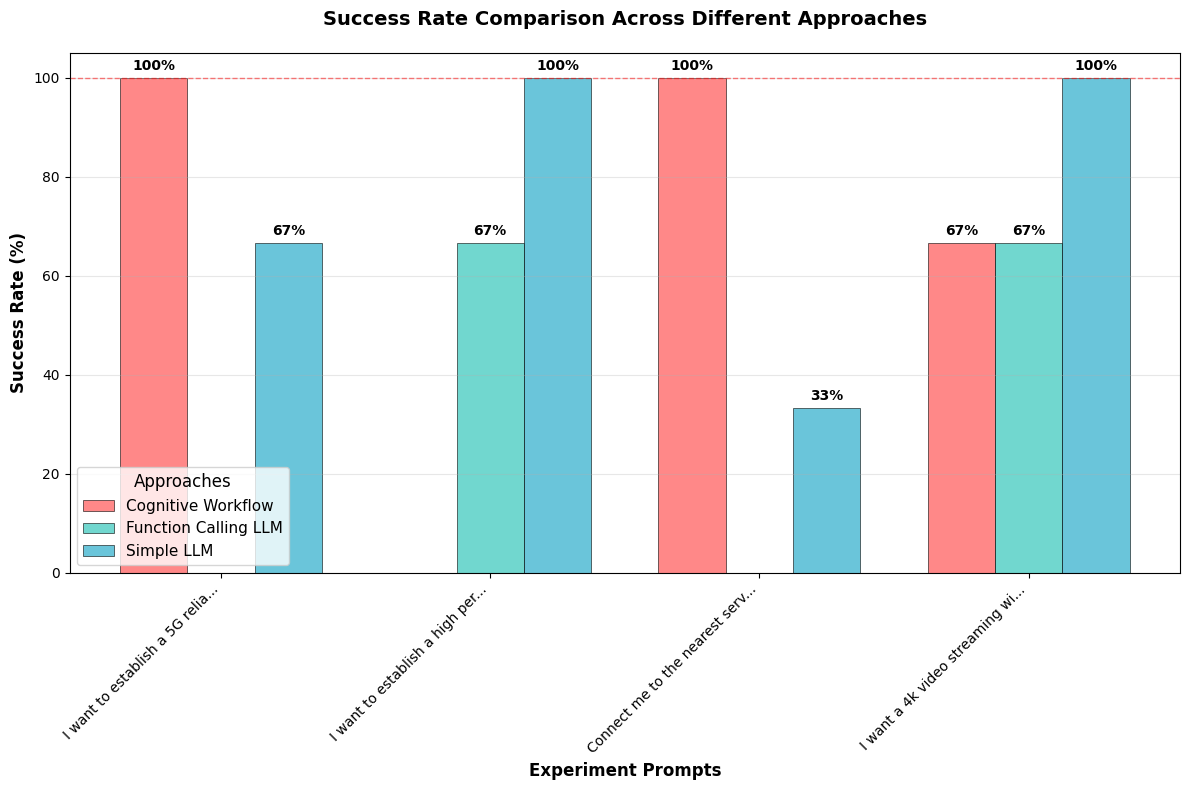

In [29]:
    experiment_batch = [
        ("I want to establish a 5G reliable connection to my friend", ["1", "3", "4"]),
        ("I want to establish a high performance connection to Gabriele for video streaming",  ["1", "2", "4"]),
        ("Connect me to the nearest server with low latency to listen my live podcast",  ["1", "3", "4"]),
        ("I want a 4k video streaming with real-time subtitles translation",  ["1", "2", "4"]),
    ]

    # Create and run batch experiments
    batch = ExperimentsBatch(experiment_batch, num_requests=3)

    # Run all experiments
    batch.run_all_experiments()

    # Plot simple success rate comparison
    batch.plot_success_rates()